<h1> Notebook for VGG16 model </h1>

ML DS Project <br>
Name : Varun Pradeep Joshi <br>
Github Username: varunjoshi29 <br>
USC ID : 1747956384 <br>

## Transfer Learning for Image Classification

**(a) In this problem, we are trying to build a classifier that distinguishes images of 20
bird species. You are provided with text data in twenty folders.**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
from collections import defaultdict
import keras
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score

In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

In [ ]:
def print_bold(text):
    print('\033[1m' + text + '\033[0m')

**(b) Data Exploration and Pre-processing**

(i) Images in each class are given in separate folders. The file Classes.xlsx provides the classes assigned to the bird species images in each folder. Therefore, you encode your classes using one-hot encoding and Classes.xlsx.

In [ ]:
base_path = '/content/drive/My Drive/Colab Notebooks/ML_DS_Project/Data'

In [ ]:
train_data_gen = ImageDataGenerator(rotation_range=50,
                                    brightness_range=[0.1, 0.7],
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=preprocess_input
                                    )

In [ ]:
valid_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
Batch_size = 10
img_h = 224
img_w = 224
num_classes=20

In [ ]:
classes = sorted(os.listdir(base_path + '/images'))

In [ ]:
classes

['005.Crested_Auklet',
 '013.Bobolink',
 '015.Lazuli_Bunting',
 '023.Brandt_Cormorant',
 '040.Olive_sided_Flycatcher',
 '041.Scissor_tailed_Flycatcher',
 '067.Anna_Hummingbird',
 '072.Pomarine_Jaeger',
 '076.Dark_eyed_Junco',
 '081.Pied_Kingfisher',
 '082.Ringed_Kingfisher',
 '086.Pacific_Loon',
 '099.Ovenbird',
 '104.American_Pipit',
 '127.Savannah_Sparrow',
 '135.Bank_Swallow',
 '141.Artic_Tern',
 '149.Brown_Thrasher',
 '156.White_eyed_Vireo',
 '168.Kentucky_Warbler']

In [ ]:
SEED = 4242
tf.random.set_seed(SEED) 

(ii) Randomly select 0.7n images from each folder as your training set, 0.15n as validation set, and the rest as your test set, where n is the number of images in folder i.

In [ ]:
import splitfolders

In [ ]:
!pip install split-folders

In [ ]:
splitfolders.ratio(base_path+'/images', 
                   output=base_path+'/op_images', 
                   seed=42, 
                   ratio=(.7, .15, .15),
                   group_prefix=None,
                   move=False
                  )

#Above code for splitting input folder into train, validation and test folders

(iii) In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [ ]:
# Train
training_dir = os.path.join(base_path+'/op_images', 'train')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(img_h, img_w),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)

# Validation
valid_dir = os.path.join(base_path+'/op_images', 'val')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(img_h, img_w),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=True,
                                           seed=SEED)
# Test
test_dir = os.path.join(base_path+'/op_images', 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             target_size=(img_h, img_w),
                                             batch_size=Batch_size, 
                                             shuffle=False,
                                             seed=SEED,
                                             class_mode=None,
                                             )

Found 826 images belonging to 20 classes.
Found 172 images belonging to 20 classes.
Found 188 images belonging to 20 classes.


**(c) Transfer Learning**

(i) When dealing with classification of relatively small image datasets, deep net- works may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning , which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those fea- tures can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement lay- ers. The dataset in this task has only around 50-60 images per class. Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained mod- els EfficientNetB0 and VGG16 . For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.i. When dealing with classification of relatively small image datasets, deep net- works may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning , which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those fea- tures can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement lay- ers. The dataset in this task has only around 50-60 images per class. Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained mod- els EfficientNetB0 and VGG16 . For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

(ii) To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV

In [ ]:
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

In [ ]:
for layer in vgg16_model.layers:
    layer.trainable = False

(iii) Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

In [ ]:
top_model = vgg16_model.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = keras.layers.BatchNormalization()(top_model) 
top_model = Dropout(0.2)(top_model)
output_layer = Dense(20, activation='softmax')(top_model)

In [ ]:
vgg16_final_model = Model(inputs=vgg16_model.input, outputs=output_layer)

In [ ]:
vgg16_final_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vgg16_final_model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [ ]:
plot_loss = PlotLossesCallback()

In [ ]:
model_checkpoint = ModelCheckpoint(filepath='model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

(iv) Train the networks ( EfficientNetB0 and VGG16) for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

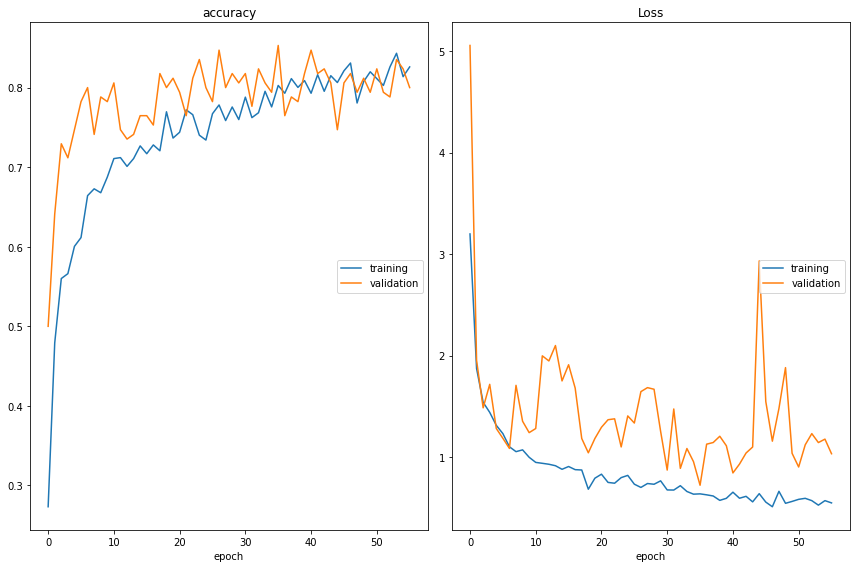

accuracy
	training         	 (min:    0.273, max:    0.843, cur:    0.826)
	validation       	 (min:    0.500, max:    0.853, cur:    0.800)
Loss
	training         	 (min:    0.509, max:    3.199, cur:    0.547)
	validation       	 (min:    0.721, max:    5.057, cur:    1.032)
82/82 [==============================] - 19s 226ms/step - loss: 0.5469 - accuracy: 0.8260 - val_loss: 1.0317 - val_accuracy: 0.8000
CPU times: user 17min 48s, sys: 38.9 s, total: 18min 27s
Wall time: 19min 3s


In [ ]:
%%time
vgg_history = vgg16_final_model.fit(train_gen,
                            batch_size=Batch_size,
                            epochs=100,
                            validation_data=valid_gen,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_steps=STEP_SIZE_VALID,
                            callbacks=[model_checkpoint, early_stop, plot_loss],
                            verbose=1)

In [ ]:
vgg16_final_model.load_weights('model_v1.weights.best.hdf5') 

true_classes = test_gen.classes
vgg_preds = vgg16_final_model.predict(test_gen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

19/19 [==============================] - 3s 140ms/step


In [ ]:
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print_bold("VGG16 Model Test Accuracy : {:.2f}%".format(vgg_acc * 100))

VGG16 Model Test Accuracy : 82.98%


(v) Report Precision, Recall, and F1 score for your model. Remember that this
is a multi-class classification problem.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(true_classes, vgg_pred_classes)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

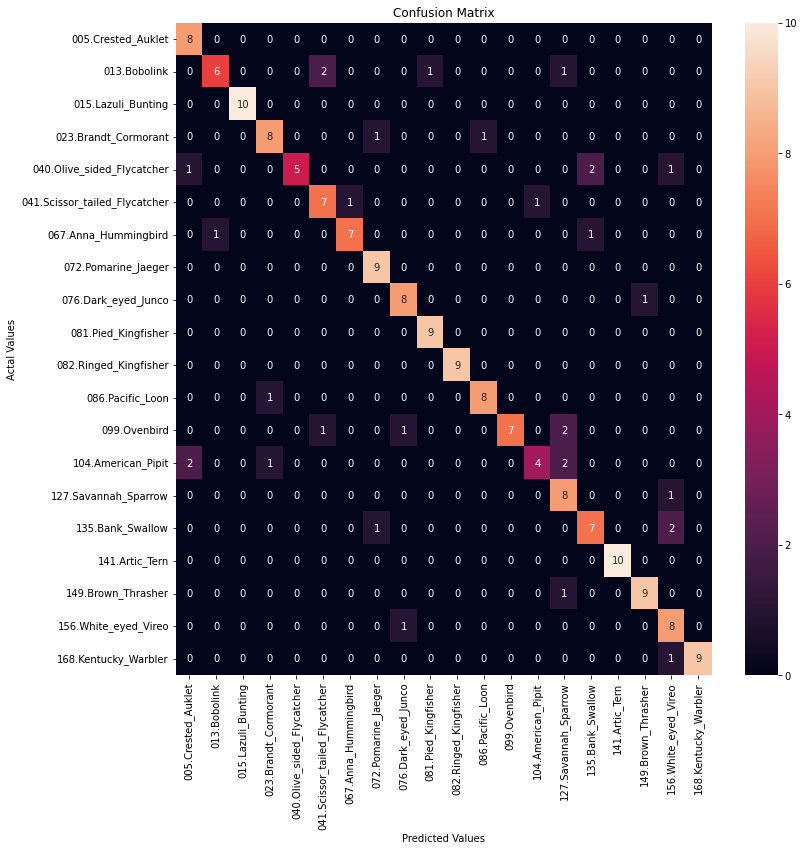

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(12,12))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(true_classes, vgg_pred_classes))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       0.86      0.60      0.71        10
           2       1.00      1.00      1.00        10
           3       0.80      0.80      0.80        10
           4       1.00      0.56      0.71         9
           5       0.70      0.78      0.74         9
           6       0.88      0.78      0.82         9
           7       0.82      1.00      0.90         9
           8       0.80      0.89      0.84         9
           9       0.90      1.00      0.95         9
          10       1.00      1.00      1.00         9
          11       0.89      0.89      0.89         9
          12       1.00      0.64      0.78        11
          13       0.80      0.44      0.57         9
          14       0.57      0.89      0.70         9
          15       0.70      0.70      0.70        10
          16       1.00      1.00      1.00        10
          17       0.90    